In [3]:
import numpy as np
import torch.nn as nn
from torch.utils.data import dataset, sampler, dataloader

# torch中数据相关组件

## Dataset


- 数据源，数据的集合
- 我们必须知道数据源的大小(```len```)，如何获得每个数据源的元素(```getitem```)
- 初始化过程中，一般会加载整个数据集合。
- ```__getitem(index)__```的index应该理解为key,Dataset可以理解成一个map

In [4]:
class MyDataSet(dataset.Dataset):
    def __init__(self,n=100) :
        self.data=list(range(n))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]

我们定义上面的数据源，然后查看元素10,20

In [5]:
ds=MyDataSet()
print(f"ds[10]={ds[10]},ds[20]={ds[20]}")

ds[10]=10,ds[20]=20


### DataSet example

我们创建一个Paddy数据的Dataset类,Paddy数的目录结构是：basepath/label/image.jpg

In [6]:
from fastai.vision.all import *
class PaddyDataSet(dataset.Dataset):
    def __init__(self,basepath='') :
        self.data=get_image_files(basepath)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        filepath=self.data[index]
        x=Image.open(filepath)
        y=parent_label(filepath)
        return x,y

创建一个数据集PaddyDataSet

ds size=10407,item=(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x640>, 'dead_heart')


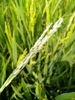

In [7]:
ds=PaddyDataSet('/Users/zhanggxk/project/paddy/data/train_images')
item=ds[10]
print(f'ds size={len(ds)},item={item}')
item[0].to_thumb(100,)


## DataLoader对象

DataLoader用于批量组合 Dataset的item,并把item转换成为tensor,准备输入给model

- 迭代一个DataLoader,会触发batch_size次调用 Dateset的getitem方法。
- Shuffle Dataset的顺序
- 在调用Dataset.getitem的时候， 使用的key是int类型，如果dataset的key是其他类型，需要传递```自定义sampler```
-  shuffle参数是对key是int类型的数据集就行随机打乱的选项，```自定义sampler``` 不能使用这个参数。
- ```collate_fn```定义了如何把 原始的batah_data(```list of items```) 进一步 转换


**以下代码有助于理解torch DataLoader的构造**
言而总之，一个DataLoader本质只需要以下三个组件

- ds: 从哪个取数据？
- batch_sampler: 每一批次取那些数据？
- collate_fn： 每一批次数据 最终的转换成什么样子？
``` python
import fastcore.all as fc
class DataLoader():
    def __init__(self,ds,batch_sampler,collate_fn):
        fc.store_attr()
    def __iter__(self):
        for b in batch_sampler:
           
            #这一步取数据可以并行处理
            batch_data=map(self.ds.__getitem__,b)
            # batch_data=(self.ds[index] for index in b)
                
            yield self.collate_fn(batch_data)

def collate_fn(batch_data):
    '''
        batch_data一般是一个generator,每次返回一个dataset的对象
    '''
    return torch.tensor(list(batch_data))
ds=range(10)
sequence_sampler=SequentialSampler(ds)
batch_sampler=BatchSampler(sequence_sampler,batch_size=3,drop_last=True)

dls=DataLoader(ds,batch_sampler,collate_fn)
for x in dls:
    print(x)
>>>
tensor([0, 1, 2])
tensor([3, 4, 5])
tensor([6, 7, 8])
```


In [ ]:
data_loader=dataloader.DataLoader(
    MyDataSet(),
    batch_size=5,
    shuffle=False,
    drop_last=False,
)
print(f"size of loader {len(data_loader)}")
print(f"one batch : {next(iter(data_loader))}")

size of loader 20
one batch : tensor([0, 1, 2, 3, 4])


### Paddy DataLoader example

In [ ]:
def collate_fn(batch_data):
    '''
        batch_data:[(img1,lb1),(img2,lb2),(img3,lb3)...]
    '''
    from torchvision import transforms as tfms
    toTensor=tfms.ToTensor()

    xs=[ toTensor(item[0].resize((32,32)) ) for item in batch_data ]
    ys=torch.tensor([ 1 for item in batch_data])

    return torch.stack(xs),ys

data_loader=dataloader.DataLoader(
    PaddyDataSet('/Users/zhanggxk/project/paddy/data/train_images'),
    batch_size=4,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn
)
print(f"size of loader {len(data_loader)}")
batch=next(iter(data_loader))

print(f"one batch : {batch[0].shape},{batch[1]}")


size of loader 2602
one batch : torch.Size([4, 3, 32, 32]),tensor([1, 1, 1, 1])


## Sampler


### Torch自带的Sampler

pytorch的Sampler分为以下几种：

- SequentialSampler，RandomSampler,本身是迭代器，目的是对`数据集的索引重新排列`。
- BatchSampler是在`索引重新排列迭代器`之上，每次返回`batch_size`个这样的索引.


**以下是BatchSampler，RamdonSampler简单的实现，有助于理解概念**
```python
import random
from itertools import islice
class RamdonSampler():
    def __init__(self,ds):
        indexes=list(range(len(ds)))
        random.shuffle(indexes)
        self.indexes=indexes
    def __iter__(self):
        yield from self.indexes

class BatchSampler():
    def __init__(self,sampler,batch_size,drop_last=False):
        fc.store_attr()
    def __iter__(self):
        n=0
        
        while True:
            #从原来的self.sampler取出batch个
            it=islice(self.sampler,n,n+self.batch_size)
            res=list(it)
            
            
            if not self.drop_last or len(res)==self.batch_size:
                yield res
            
            if len(res)<self.batch_size:
                return
            n+=self.batch_size
            # break
            
```

In [19]:
from torch.utils.data import RandomSampler,SequentialSampler,BatchSampler,DataLoader

1.SequentialSampler，RandomSampler 例子

In [8]:
ds=range(10)

r_sampler=RandomSampler(ds)
print('RandomSampler:',list(r_sampler))

s_sampler=SequentialSampler(ds)
print('SequentialSampler:',list(s_sampler))

RandomSampler: [2, 4, 6, 8, 1, 9, 3, 0, 5, 7]
SequentialSampler: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


2.BatchSampler 例子

In [34]:
ds=range(10)
r_sampler=range(len(ds))
b_sampler=BatchSampler(r_sampler,batch_size=3,drop_last=False)
print('BatchSampler:',list(b_sampler))

BatchSampler: [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]


3.使用BatchSampler定义DataLoader

In [28]:
ds=['A','B','C','D','E','F','G','H','I']

r_sampler=RandomSampler(ds)
batch_sampler=BatchSampler(r_sampler,batch_size=4,drop_last=False)
dls=DataLoader(ds,batch_sampler=batch_sampler)

for x in dls:
    print(x)

['D', 'B', 'G', 'E']
['I', 'F', 'H', 'A']
['C']


4.我们可以简化写法，只定义batch_size,然后把Sampler传递给DataLoader的构造函数，这样DataLoader会自动给我们创建一个BatchSampler.

In [31]:
ds=['A','B','C','D','E','F','G','H','I']

r_sampler=RandomSampler(ds)
dls=DataLoader(ds,batch_size=4,sampler=r_sampler)

for x in dls:
    print(x)

['B', 'G', 'D', 'C']
['H', 'E', 'I', 'F']
['A']


5.由于RandomSampler，SequentialSampler被经常使用，DataLoader还允许我们直接传递`shuffle`参数觉得使用那个Sampler,DataLoader自动帮我们创建BatchSamper,RandomSampler或者SequentialSampler。

In [35]:
ds=['A','B','C','D','E','F','G','H','I']


dls=DataLoader(ds,batch_size=4,shuffle=True)

for x in dls:
    print(x)

['B', 'E', 'G', 'C']
['D', 'I', 'F', 'A']
['H']


## 自定义Sampler



Sampler的作用是 从Dataset中，为一个batch 返回 索引。

* 返回的索引的元素需要```__get_item(index)__```的index类型兼容。
* Sampler也要知道Dataset的大小，这样才能确定返回索引的范围
* 本质是一个迭代器。

In [ ]:
class MyRandomSampler(sampler.Sampler):
    def __init__(self,ds_size=100):
        self.ds_size=ds_size
    def __iter__(self):
        return iter(np.random.permutation(range(self.ds_size)))

for x in iter(MyRandomSampler(10)):
    print(x,end=' ')

3 4 5 9 1 8 0 7 2 6 

下面的demo做了一个对比，没有加入MySampler的data_loader返回的batch是固定顺序的，加入MySampler的data_loader返回的batch是随机的排列。

In [ ]:
data_loader=dataloader.DataLoader(
    MyDataSet(n=15),
    batch_size=3,
    drop_last=False,
)

for x in data_loader:
    print(x,end=' ')


data_loader=dataloader.DataLoader(
    MyDataSet(n=15),
    batch_size=3,
    drop_last=False,
    sampler=MyRandomSampler(15),
)
print()
for x in data_loader:
    print(x,end=' ')

tensor([0, 1, 2]) tensor([3, 4, 5]) tensor([6, 7, 8]) tensor([ 9, 10, 11]) tensor([12, 13, 14]) 
tensor([12,  8,  9]) tensor([7, 4, 2]) tensor([14,  1, 11]) tensor([0, 5, 6]) tensor([ 3, 10, 13]) 

###  与DataSet index兼容的 Sampler

下面的例子中：

* TupleDataSet key=tutle(),value=key中索引对于的值
* TupleSampler 的迭代器返回2个key,分别是(i,i+1)
* collate_fn是整理函数，输入是 MyDataset的value,这里选择原样返回！

In [ ]:
class TupleDataSet(dataset.Dataset):
    def __init__(self,n=100) :
        self.data=list(range(n))
    def __getitem__(self, key):   
        v=self.data  
        return v[key[0]],v[key[1]]
    def __len__(self):
        return 10
ds=TupleDataSet(10)
print(f"ds[(2,3)]={ds[(2,3)]}")

ds[(2,3)]=(2, 3)


In [ ]:
class TupleSampler(sampler.Sampler):
    def __init__(self,ds_size):
        self.ds_size=ds_size
    def __iter__(self):
        r=[(i,(i+1)%self.ds_size) for i in range(self.ds_size)]
        return iter(r)
    
data_loader=dataloader.DataLoader(
    TupleDataSet(10),
    batch_size=3,
    shuffle=False,
    drop_last=False,
    sampler=TupleSampler(10),
    collate_fn=lambda x:x
)
for x in data_loader:
    print(x)

[(0, 1), (1, 2), (2, 3)]
[(3, 4), (4, 5), (5, 6)]
[(6, 7), (7, 8), (8, 9)]
[(9, 0)]


## 分布式数据组件

### DDP(Distribute Data Parallel)


- 每个GPU上都有相同的模型
- 数据分散到不同的GPU上，进行forward,backward
- 使用Ring All Reduce 算法，同步不同GPU上的grad
- 更新grad

|设备|  权重 |
| - | - |
| G0| w0 |
| G1| w1 |
| G2| w2 |
| G3| w3 |

G0->G1->G2->G3->G0

第一轮同步
|设备|  权重 |
| - | - |
| G0| w3+w0 |
| G1| w0+w1 |
| G2| w1+w2 |
| G3| w2+w3 |

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import torch.multiprocessing as mp
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

In [ ]:
class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = nn.Linear(10, 10)
        self.relu = nn.ReLU()
        self.net2 = nn.Linear(10, 5)

    def forward(self, x):
        return self.net2(self.relu(self.net1(x)))

In [ ]:
def demo_basic(rank, world_size):
    print(f"Running basic DDP example on rank {rank}.")
    setup(rank, world_size)

    # create model and move it to GPU with id rank
    model = ToyModel().to(rank)
    ddp_model = DDP(model, device_ids=[rank])

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(ddp_model.parameters(), lr=0.001)


    xs=torch.randn(20, 10)
    labels = torch.randn(20, 5).to(rank)

    for i in range(200):
        optimizer.zero_grad()
        outputs = ddp_model(xs)
        loss_fn(outputs, labels).backward()
        optimizer.step()

    cleanup()

In [ ]:
def run_demo(world_size):
    mp.spawn(demo_basic,
             args=(world_size,),
             nprocs=world_size,
             join=True)

# 问题：
- 如何把Image转换成tensor
- 完成一个image,label的完整的dataloader,包括转成tensor,normal,...

from torchvision import transforms as tfms